# Single-cell Analysis of HCA data with Seurat 
In this Jupyter Notebook, we explore how to import HCA data and perform single-cell analysis (filtering, clustering, and differential gene expression) using Seurat, a suite of tools written in R for single-cell analysis ([Butler et al. 2018](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8); [Stuart et al. 2020](https://www.nature.com/articles/nbt.4096)). 

This Seurat tutorial has been modified from the tutorial available in the [Seurat Vignettes](https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html). 

It uses subsampled human liver data (332,497 unfiltered cells) from the HCA project ["Dissecting the human liver cellular landscape by single cell RNA-seq reveals novel intrahepatic monocyte/ macrophage populations"](https://data.humancellatlas.org/explore/projects/4d6f6c96-2a83-43d8-8fe1-0f53bffd4674).

Learn more about the data in "[Single cell RNA sequencing of human liver reveals distinct intrahepatic macrophage populations](https://www.nature.com/articles/s41467-018-06318-7)" (MacParland et al., 2018). 

Overall, the tutorial provides step-by-step instructions for:

- Importing and exploring HCA data files
- Filtering and visualizing cells based on QC metrics
- Normalizing single-cell data
- Identifying highly variable features (feature selection)
- Scaling and performing linear dimensional reduction
- Clustering cells
- Performing non-linear dimensional reduction
- Performing differential expression analysis

DISCLAIMER

This Notebook is designed to showcase Jupyter Notebook analysis of HCA data in Terra rather than teach single-cell analysis. The Seurat tutorial has been modified to exclude some detailed information related to the highlighted Seurat tools and analysis. To learn more about the features highlighted here, we encourage you to review the original [Seurat tutorial](https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html) as well as the [Seurat documentation](https://satijalab.org/seurat/).

## Notebook set-up

### Setting the Cloud Environment
This notebook uses the Terra R/Bioconductor base image (Python 3.7.10, R4.0.5) which you can select from the Cloud Environment widget at the top right of the Workspace. 

**Important! Please note the compute requirements for this notebook:**
- Select **4 CPUs** under the cloud compute profile in the Cloud Environment widget
- If you update the kernel after starting the notebook, delete the environment AND associated persistent disk before re-running the notebook

### Running the notebook
Prior to starting the notebook, we recommend restarting and clearing the kernel to remove outputs that were previously generated. This will help you understand what each code block is doing as the code is running. 

You can run the code blocks in this tutorial all at one time, or one-by-one. If you run each code block individually, make sure to run them in sequential order.

**Running all cells at one time**

To run all, select the "Cell" drop-down at the top of the notebook and choose "Run All".

**Running each cell individually**

You can run each cell individually in one of the following ways:
- Clicking the `Run` icon at the top of the notebook
- Using the shortcut shift return

## Installing notebook packages
Seurat is pre-installed on the R/Bioconductor base image in Terra. However, the code below installs additional Bioconductor and R packages (including the AnVIL and sceasy packages) that are useful for manipulating cloud files and for single-cell analysis.

#### What is the AnvIL package? 
The Bioconductor [AnVIL package](https://bioconductor.org/packages/release/bioc/html/AnVIL.html) is a suite of tools for working with Terra workspaces, data tables and external cloud resources, and includes utilities for movings files between cloud storage and the Terra Cloud Environment.

#### What is the sceasy package?
The sceasy package is a suite of tools for converting between file formats commonly used for single-cell analysis, such as Loom, AnnData (h5ad), and SingleCellExperiment (RDS). 

The code below installs the sceasy package following instructions in readme: https://github.com/cellgeni/sceasy. However, it does not use the conda option for installing anndata and loompy. Instead, anndata and loompy are installed using the `system()` command below.

In [1]:
# Installing sceasy-related packages
install.packages('reticulate')
system('pip install -U loompy', intern=FALSE)
system('pip install anndata', intern=FALSE)

# Installing Bioconductor packages
install_if_missing <- function(packages) {
    packages_needed <- setdiff(packages, rownames(installed.packages()))
    if (length(packages_needed) > 0) { 
        BiocManager::install(packages_needed)
    }
}

packages_for_this_notebook <- c(
    "AnVIL",
    "LoomExperiment",
    "SingleCellExperiment")

install_if_missing(packages_for_this_notebook)

library(AnVIL)
library(LoomExperiment)
library(reticulate)

Installing package into ‘/home/jupyter/notebooks/packages’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cloud.r-project.org


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.0 (2021-05-18)

Installing package(s) 'AnVIL', 'LoomExperiment'

also installing the dependencies ‘Rhdf5lib’, ‘rhdf5filters’, ‘rapiclient’, ‘rhdf5’, ‘HDF5Array’


Old packages: 'beachmat', 'bigrquery', 'BiocParallel', 'biomaRt', 'Biostrings',
  'blob', 'broom', 'cachem', 'cli', 'credentials', 'DelayedMatrixStats',
  'ensembldb', 'future', 'future.apply', 'GenomeInfoDb', 'GenomicFeatures',
  'gert', 'googlesheets4', 'haven', 'htmltools', 'httpuv', 'isoband', 'jpeg',
  'later', 'leiden', 'limma', 'MatrixGenerics', 'matrixStats', 'parallelly',
  'pillar', 'R6', 'RcppAnnoy', 'RcppArmadillo', 'RCurl', 'readr', 'reprex',
  'rmarkdown', 'RSQLite', 'rtracklayer', 'rvest', 'scuttle', 'Seurat',


In [2]:
# Installing sceasy package
devtools::install_github("cellgeni/sceasy")

RcppAnnoy    (0.0.18     -> 0.0.19    ) [CRAN]
utf8         (1.2.1      -> 1.2.2     ) [CRAN]
cli          (3.0.0      -> 3.0.1     ) [CRAN]
pillar       (1.6.1      -> 1.6.2     ) [CRAN]
spatstat.... (2.2-0      -> 2.2-2     ) [CRAN]
cachem       (1.0.5      -> 1.0.6     ) [CRAN]
later        (1.2.0      -> 1.3.0     ) [CRAN]
R6           (2.5.0      -> 2.5.1     ) [CRAN]
htmltools    (0.5.1.1    -> 0.5.2     ) [CRAN]
httpuv       (1.6.1      -> 1.6.2     ) [CRAN]
stringi      (1.6.2      -> 1.7.4     ) [CRAN]
tibble       (3.1.2      -> 3.1.4     ) [CRAN]
isoband      (0.2.4      -> 0.2.5     ) [CRAN]
parallelly   (1.26.1     -> 1.27.0    ) [CRAN]
RcppArmad... (0.10.5.0.0 -> 0.10.6.0.0) [CRAN]
matrixStats  (0.59.0     -> 0.60.1    ) [CRAN]
future       (1.21.0     -> 1.22.1    ) [CRAN]
future.apply (1.7.0      -> 1.8.1     ) [CRAN]
spatstat.... (2.2-0      -> 2.3-0     ) [CRAN]
leiden       (0.3.8      -> 0.3.9     ) [CRAN]
Seurat       (4.0.3      -> 4.0.4     ) [CRAN]


Skipping 2 packages not available: LoomExperiment, SingleCellExperiment

Installing 21 packages: RcppAnnoy, utf8, cli, pillar, spatstat.geom, cachem, later, R6, htmltools, httpuv, stringi, tibble, isoband, parallelly, RcppArmadillo, matrixStats, future, future.apply, spatstat.core, leiden, Seurat

Installing packages into ‘/home/jupyter/notebooks/packages’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘leiden’ had non-zero exit status”


✔  checking for file ‘/tmp/RtmpbfIVMK/remotes9b595fa293/cellgeni-sceasy-f8f0628/DESCRIPTION’
─  preparing ‘sceasy’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘sceasy_0.0.6.tar.gz’
   


Installing package into ‘/home/jupyter/notebooks/packages’
(as ‘lib’ is unspecified)



In [3]:
library(sceasy)

In [4]:
loompy <- reticulate::import('loompy')

## Installing environment variables
The following code uses AnVIL functions to assign several environment variables that allow you to access and manipulate Terra featues like the workspace name, Google bucket, and Google billing project. 

In [5]:
# Assign environment variables and view them
project <- avworkspace_namespace()
workspace <- avworkspace()
bucket <- avbucket()
project
workspace
bucket

[1] "featured-workspaces-hca"

[1] "featured-workspaces-hca/Intro-to-HCA-data-on-Terra-lk-20210901-notebook"

[1] "gs://fc-7324e65c-4d56-4a2e-973a-9c8f405bfce6"

## Examine file details for the HCA project matrix
HCA and other consortia data files live in cloud storage, like Google buckets, Amazon Web Services, and Azure. Since files can live in diverse storage options, they are often given a cloud agnostic GA4GH-compliant identifier called a DRS URI (read more in this Terra Support [overview](https://support.terra.bio/hc/en-us/articles/360039330211)) 

- In this tutorial, we'll identify and move files between cloud environments using their DRS URIs. You can find an HCA data file's DRS URI by looking for the DRS URI column in the  `participant` data table that Terra automatically creates when you import data. 



- For this tutorial's example project matrix (sc-landscape-human-liver-10XV2.loom), you'll find the DRS URI in the table's  `__loom__file_drs_uri` column. 



- The AnVIL package provides the `drs_stat()` function as a useful way to look up files by DRS URIs and examine the the details before moving or manipulating the files.



- Before using the function, we'll assign it to a variable (`drs_url`) so that we can reuse the variable with other functions later in the notebook. 


- The table output below will show the file's name, size, date updated, and url for it's Google bucket location (in the "gsUri" column). 

In [6]:
# Look at DRS URI info for the 10x project matrix :`sc-landscape-human-liver-10XV2.loom`
drs_url <- 'drs://jade-terra.datarepo-prod.broadinstitute.org/v1_4c9d9b2d-a469-40bc-b79b-c3465c154675_57130684-c89c-4b27-9030-298f50cbc95c'
stats <- drs_stat(drs_url)
stats

fileName,size,contentType,gsUri,timeCreated,timeUpdated,bucket,name,googleServiceAccount,hashes
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<list>,<list>
sc-landscape-human-liver-10XV2.loom,1176122907,NA,gs://broad-datarepo-terra-prod-hca2-bucket/d30e68f8-c826-4639-88f3-ae35f00d4185/57130684-c89c-4b27-9030-298f50cbc95c/sc-landscape-human-liver-10XV2.loom,2021-02-19T19:31:35.668Z,2021-02-19T19:31:35.668Z,broad-datarepo-terra-prod-hca2-bucket,d30e68f8-c826-4639-88f3-ae35f00d4185/57130684-c89c-4b27-9030-298f50cbc95c/sc-landscape-human-liver-10XV2.loom,NULL,"b01eb717 , 9b990461e64e4c35fa67e466c4a22cba"


## Importing HCA data into the Cloud Environment
The AnVIL package uses the `drs_cp()` function to copy and move files with a DRS URI. 

The code below will automatically import the file into our virtual machine's [persistent disk](https://support.terra.bio/hc/en-us/articles/360047318551) file location. 

In [7]:
# Copy file with DRS URI into Cloud Envrionment
drs_cp(drs_url, ".")

fileName,size,contentType,gsUri,timeCreated,timeUpdated,bucket,name,googleServiceAccount,hashes,simple,destination
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<list>,<list>,<lgl>,<chr>
sc-landscape-human-liver-10XV2.loom,1176122907,NA,gs://broad-datarepo-terra-prod-hca2-bucket/d30e68f8-c826-4639-88f3-ae35f00d4185/57130684-c89c-4b27-9030-298f50cbc95c/sc-landscape-human-liver-10XV2.loom,2021-02-19T19:31:35.668Z,2021-02-19T19:31:35.668Z,broad-datarepo-terra-prod-hca2-bucket,d30e68f8-c826-4639-88f3-ae35f00d4185/57130684-c89c-4b27-9030-298f50cbc95c/sc-landscape-human-liver-10XV2.loom,NULL,"b01eb717 , 9b990461e64e4c35fa67e466c4a22cba",TRUE,./sc-landscape-human-liver-10XV2.loom


### Copying HCA data using gsutil
Since HCA data is stored in a Google bucket, we can also use Google's suite of tools for manipulating cloud data, [gsutil](https://cloud.google.com/storage/docs/gsutil). Forunately, the AnVIL package has gsutil built in. If you want to try it, just uncomment the code below. 

Same as above, this technique will import the file into our [persistent disk](https://support.terra.bio/hc/en-us/articles/360047318551) file location. 

We used the `drs_stat()` function above to find the Google bucket URI, but you can also find this information in the `participant` data table. When you click the project matrix DRS URI link in the table's `__loom__file_drs_uri` column, you'll notice a new window with a gsutil command for copying the file from a Google bucket location. This command contains the Google bucket URI. 

In [8]:
# home <- "/home/jupyter-user/notebooks/Intro-to-HCA-data-on-Terra-notebook-dev/edit"
# gs <- "gs://broad-datarepo-terra-prod-hca2-bucket/d30e68f8-c826-4639-88f3-ae35f00d4185/57130684-c89c-4b27-9030-298f50cbc95c/sc-landscape-human-liver-10XV2.loom"
# gsutil_cp(gs, home)

After importing the project matrix, we can confirm the import by listing files in our Cloud Environment's virtual machine. You should see the `sc-landscape-human-liver-10XV2.loom` file is now your Cloud Environment's file system.

In [9]:
# Confirm that `sc-landscape-human-liver-10XV2.loom` is in Cloud Environment disk
list.files()

[1] "Bioconductor.ipynb"                  "Pegasus.ipynb"                      
[3] "sc-landscape-human-liver-10XV2.loom" "Scanpy.ipynb"                       
[5] "Seurat.ipynb"

## Convert the Loom to AnnData with sceasy
To convert the HCA Loom to a Seurat object, we must first convert it to an intermediary AnnData object using the sceasy package.

The code below uses the sc-landscape-human-liver-10XV2.loom file as input and creates the output AnnData object which we'll store in an h5ad file called "trial_liver.h5ad."

In [10]:
# Convert to AnnData with sceasy; conversion takes a few minutes
sceasy::convertFormat('sc-landscape-human-liver-10XV2.loom', from="loom", to="anndata",
                       outFile='trial_liver.h5ad')

AnnData object with n_obs × n_vars = 332497 × 58347
    obs: 'cell_barcode_fraction_bases_above_30_mean', 'cell_barcode_fraction_bases_above_30_variance', 'cell_names', 'emptydrops_FDR', 'emptydrops_IsCell', 'emptydrops_Limited', 'emptydrops_LogProb', 'emptydrops_PValue', 'emptydrops_Total', 'fragments_per_molecule', 'fragments_with_single_read_evidence', 'genes_detected_multiple_observations', 'genomic_read_quality_mean', 'genomic_read_quality_variance', 'genomic_reads_fraction_bases_quality_above_30_mean', 'genomic_reads_fraction_bases_quality_above_30_variance', 'input_id', 'molecule_barcode_fraction_bases_above_30_mean', 'molecule_barcode_fraction_bases_above_30_variance', 'molecules_with_single_read_evidence', 'n_fragments', 'n_genes', 'n_mitochondrial_genes', 'n_mitochondrial_molecules', 'n_molecules', 'n_reads', 'pct_mitochondrial_molecules', 'perfect_cell_barcodes', 'perfect_molecule_barcodes', 'reads_mapped_exonic', 'reads_mapped_intergenic', 'reads_mapped_intronic', 'reads_ma

## Sanity check
Make sure the trial_liver.h5ad is now in the working directory by listing the files.

In [11]:
list.files()

[1] "Bioconductor.ipynb"                  "Pegasus.ipynb"                      
[3] "sc-landscape-human-liver-10XV2.loom" "Scanpy.ipynb"                       
[5] "Seurat.ipynb"                        "trial_liver.h5ad"

## Convert the AnnData to Seurat
A Seurat object is a container that holds count information from our count matrix, but also analysis results like PCA and clustering info.

Let's use the sceasy package to convert the trial_liver.h5ad to a Seurat object and write the object to an RDS file called "liver_seurat.rds".

In [12]:
# Use sceasy to convert AnnData to Seurat
sceasy::convertFormat('trial_liver.h5ad', from="anndata", to="seurat",
                       outFile='liver_seurat.rds')

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
X -> counts



An object of class Seurat 
58347 features across 332497 samples within 1 assay 
Active assay: RNA (58347 features, 0 variable features)

## Load libraries to explore the single-cell data in Seurat 

In [13]:
# Load libraries needed for using Seurat
library(dplyr)
library(Seurat)
library(patchwork)

Attaching SeuratObject


Attaching package: ‘Seurat’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays




## Sanity check
Let's list the files to make sure the liver_seurat.rds file is in the working directory.

In [14]:
list.files()

[1] "Bioconductor.ipynb"                  "liver_seurat.rds"                   
[3] "Pegasus.ipynb"                       "sc-landscape-human-liver-10XV2.loom"
[5] "Scanpy.ipynb"                        "Seurat.ipynb"                       
[7] "trial_liver.h5ad"

## Read the Seurat object
We'll assign the RDS file to the variable "liver" so that we can manipulate it throughout the tutorial.

In [15]:
liver <- readRDS(file = "liver_seurat.rds")

## Explore the Seurat object
You should see that the liver variable is an object of class Seurat with 58,347 features and 332,497 samples (unfiltered cells) within 1 assay.

In [16]:
# Look at the Seurat object
liver

An object of class Seurat 
58347 features across 332497 samples within 1 assay 
Active assay: RNA (58347 features, 0 variable features)

## Subset the project matrix
We'll subset the matrix and only look at one donor. This will shorten the amount of time it takes to run some Seurat commands. We will subset the data to the donor with the ID `02f207ae-217b-42ce-9733-c03e61541fcc`.

Note that project matrices contain raw counts from multiple donors and are not corrected for batch effects.

In [17]:
liver <- subset(liver, subset = input_id == "02f207ae-217b-42ce-9733-c03e61541fcc")
liver

An object of class Seurat 
58347 features across 87538 samples within 1 assay 
Active assay: RNA (58347 features, 0 variable features)

If we look at all the input_ids for the different donors, we see we're only using the one we specified in the subset.

In [18]:
summary(liver$input_id)

2b965070-e2c5-4c26-92c9-c94483f1a00c 02f207ae-217b-42ce-9733-c03e61541fcc 
                                   0                                87538 
3f9058b9-4243-4ef1-a345-857a5b9ff78e 42998245-4c46-488e-ad04-14550074d6d4 
                                   0                                    0 
d1782f60-75d3-41a2-a6d5-8218daab2e31 
                                   0

## Filtering and visualizing cells based on QC metrics
Seurat allows you to filter cells based on common QC metrics, such as the number of UMIs, unique feature counts and the percent of mitochondrial reads, which can indicate low-quality or dying cells. 

10x matrices that were produced with standardized pipelines like [Optimus](https://data.humancellatlas.org/pipelines/optimus-workflow) have multiple quality metrics already available, like the percent of mitochondrial molecules and the number of UMIs. 



We can use the `VlnPlot()` function to visualize these QC metrics in violin plots.

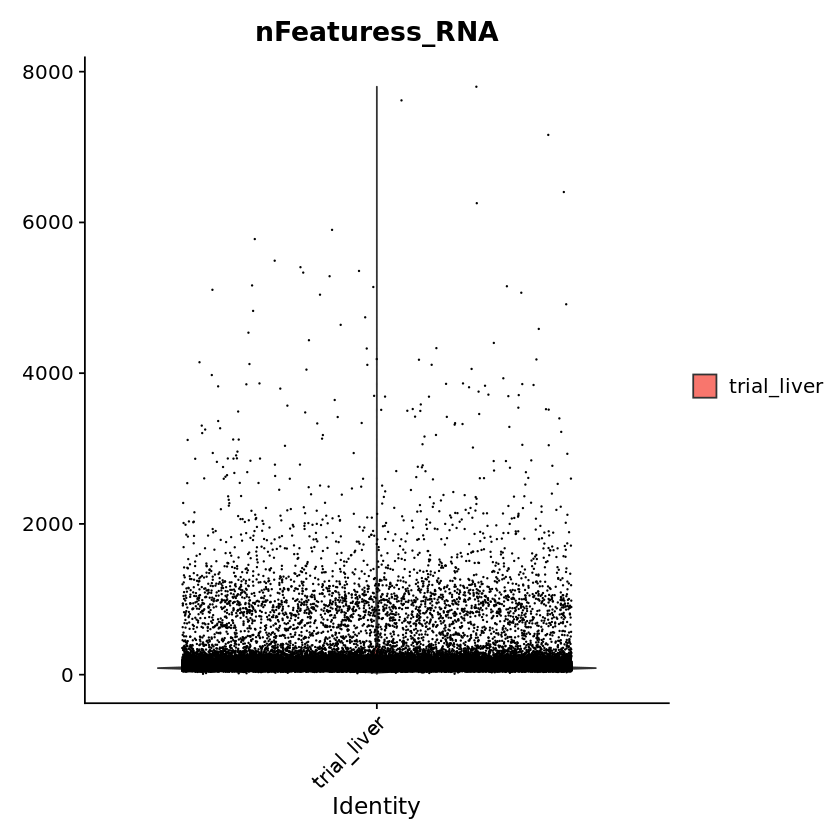

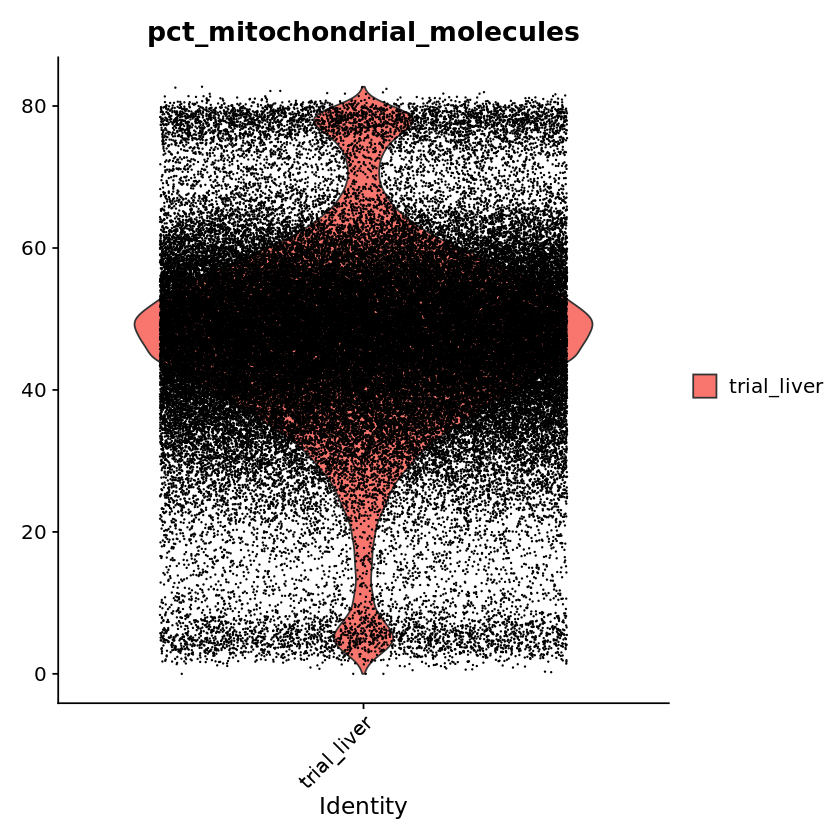

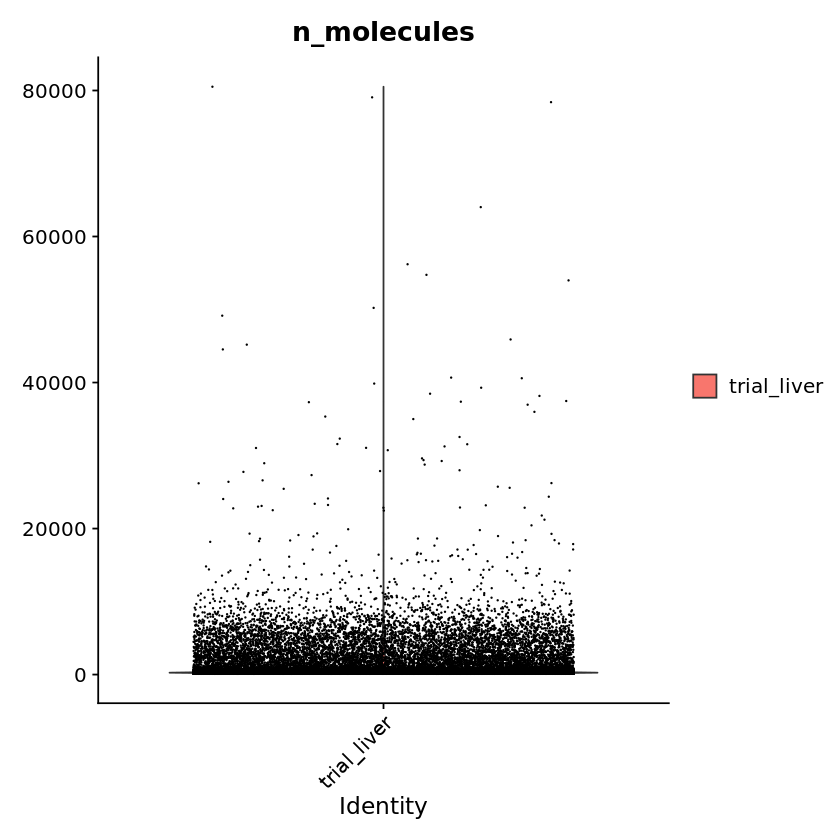

In [19]:
# Visualize QC metrics as a violin plot
VlnPlot(liver, features = "nFeaturess_RNA", ncol = 1)
VlnPlot(liver, features = "pct_mitochondrial_molecules", ncol = 1)
VlnPlot(liver, features = "n_molecules", ncol = 1)

After visualizing the metrics, we can filter the cells based on the filtering criteria used in the [Seurat tutorial](https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html). 

In [20]:
# Filtering cells
liver <- subset(liver, subset = nFeaturess_RNA > 200 & nFeaturess_RNA < 2500 & pct_mitochondrial_molecules < 5)

## Normalizing single-cell data

Seurat uses a default global-scaling normalization method `LogNormalize` which normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. 

In [21]:
liver <- NormalizeData(liver, normalization.method = "LogNormalize", scale.factor = 10000)


## Identifying highly variable features (feature selection)

Identifying genes and other features that are highly variable from cell-to-cell can help highlight biological signal. Seurat uses the `FindVariableFeatures()` function to identify variable features and return 1,000 features per dataset.

We can idenitfy the most highly variable features (i.e. take the top 10) by looking at the `VariableFeatures` attribute.

In [22]:
liver <- FindVariableFeatures(liver, selection.method = "vst", nfeatures = 1000)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.9835”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.50344”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  1.103e-15”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.090619”


In [23]:
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(liver), 10)
top10

[1] "HBD"    "CA1"    "HBM"    "AHSP"   "S100A8" "S100A9" "HBA2"   "CA2"   
 [9] "IGKC"   "HBA1"

In [24]:
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(liver)

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 36804 rows containing missing values (geom_point).”


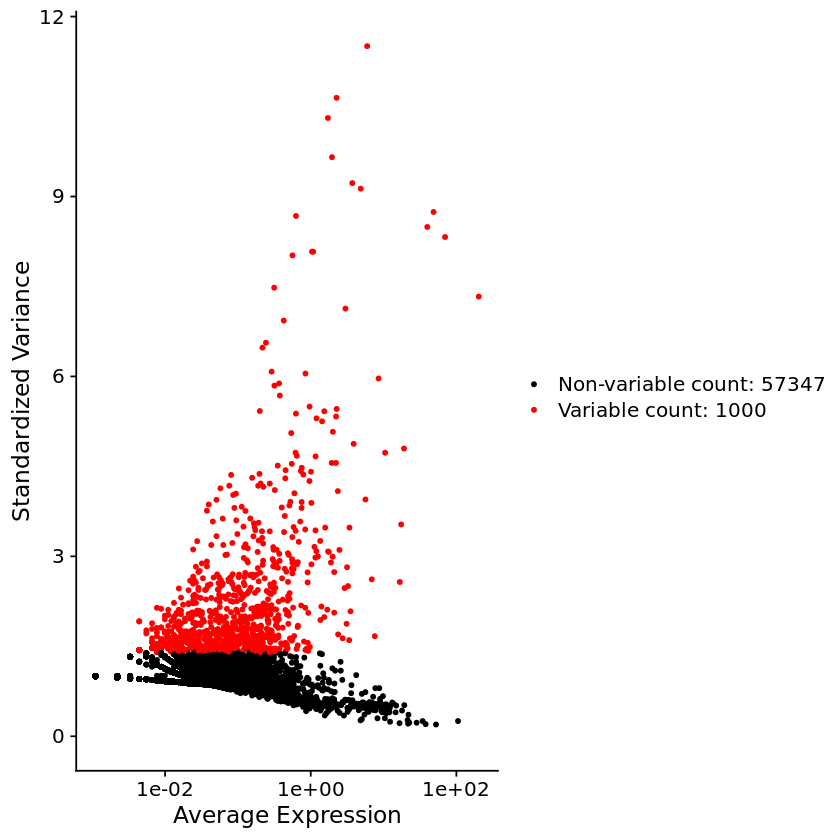

In [25]:
plot1

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 36804 rows containing missing values (geom_point).”


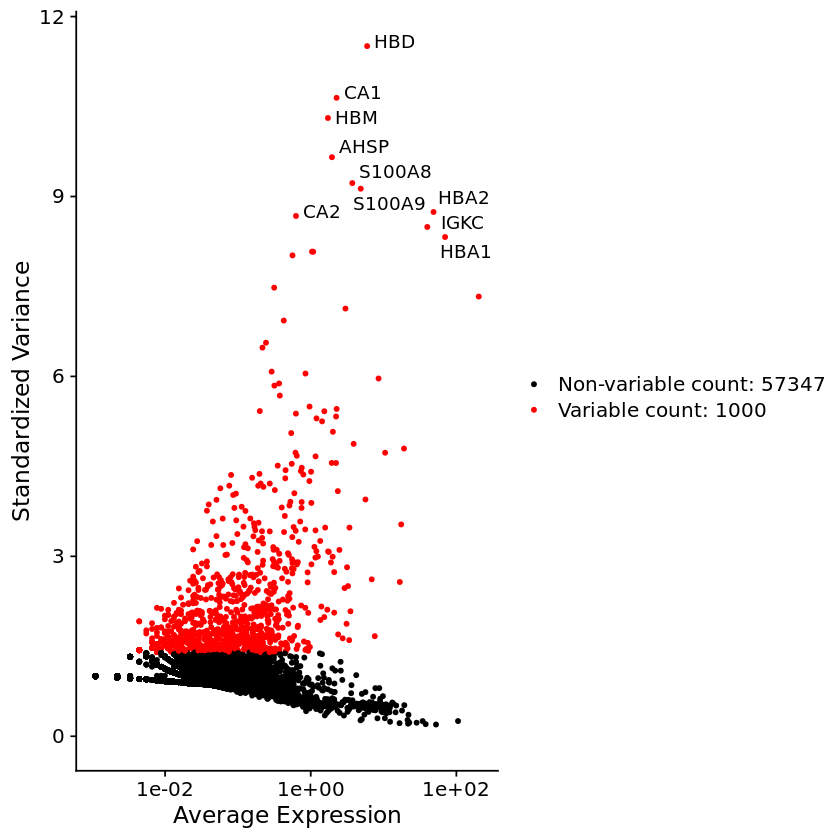

In [26]:
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot2

## Scaling data and performing linear dimensional reduction

To prevent highly-expressed genes from dominating downstream results, Seurat applies a linear transformation ('scaling') that is a standard pre-processing step prior to dimensional reduction techniques like PCA. 

The `ScaleData()` function:

* Shifts the expression of each gene, so that the mean expression across cells is 0
* Scales the expression of each gene, so that the variance across cells is 1


Note: this step takes a few minutes to complete because we're using all genes (`features = all.genes`). If we only looked at the 1,000 features, we could speed this step up.


In [27]:
# This step takes several minutes
all.genes <- rownames(liver)
liver <- ScaleData(liver, features = all.genes)

Centering and scaling data matrix



### Principle Component Analysis (PCA)
Seurat can perform PCA on the scaled data using the `RunPCA` function.

By default, only the previously determined variable features are used as input, but can be defined using features argument if you wish to choose a different subset.

In [28]:
liver <- RunPCA(liver, features = VariableFeatures(object = liver))

PC_ 1 
Positive:  ID3, TM4SF1, TFPI, HSPG2, IGFBP7, ID1, C7, PRSS23, ADIRF, APP 
	   IFI27, LIFR, NR2F2, RAMP3, IFITM3, PTPRB, TIMP3, TIMP1, IL33, TGM2 
	   CAVIN2, GNG11, SRPX, CALCRL, VWF, IL6ST, NPDC1, MYCT1, HES1, RNASE1 
Negative:  S100A4, CCL4, CD52, TYROBP, KLRB1, CCL3, FCER1G, UCP2, CMC1, AREG 
	   CCL3L3, GNLY, XCL2, RGS1, GZMH, LTB, HBB, RGS2, RNASET2, HBA2 
	   CCL4L2, LINC01871, ALAS2, IL7R, AHSP, SLC4A1, HBD, XCL1, CA1, HBM 
PC_ 2 
Positive:  SLC4A1, AHSP, GYPA, HBD, ALAS2, HBM, CA1, GYPB, RHCE, CA2 
	   SNCA, HEMGN, HBA2, HBA1, KLF1, EPB42, HBB, HMBS, SLC25A37, RHAG 
	   FECH, SLC25A39, TRIM58, TSPO2, RFESD, HBQ1, SLC2A1, RHD, MYL4, GYPE 
Negative:  AIF1, LYZ, AC020656.1, CTSS, LST1, CST3, CD163, CFD, S100A9, CLEC7A 
	   MAFB, FCN1, FTL, CSTA, VSIG4, VCAN, LGALS1, MNDA, GRN, CXCL8 
	   CSF3R, GPX1, TYROBP, S100A8, MS4A7, HLA-DRA, IGSF6, PSAP, S100A11, MPEG1 
PC_ 3 
Positive:  KLRB1, CMC1, CCL4, GNLY, FKBP11, XCL2, GZMH, LINC01871, LTB, XCL1 
	   IL7R, IFNG, TRGC2, FGFBP2,

### Detemining the 'dimensionality' of the dataset
To overcome the extensive technical noise in any single feature for scRNA-seq data, Seurat clusters cells based on their PCA scores, with each PC essentially representing a 'metafeature' that combines information across a correlated feature set. The top principal components therefore represent a robust compression of the dataset. However, how many componenets should we choose to include? 10? 20? 100?

For this tutorial, we identify the number of PCs by using the `ElbowPlot()` function to generate an 'Elbow plot': a ranking of principle components based on the percentage of variance explained by each one (`ElbowPlot()` function). 


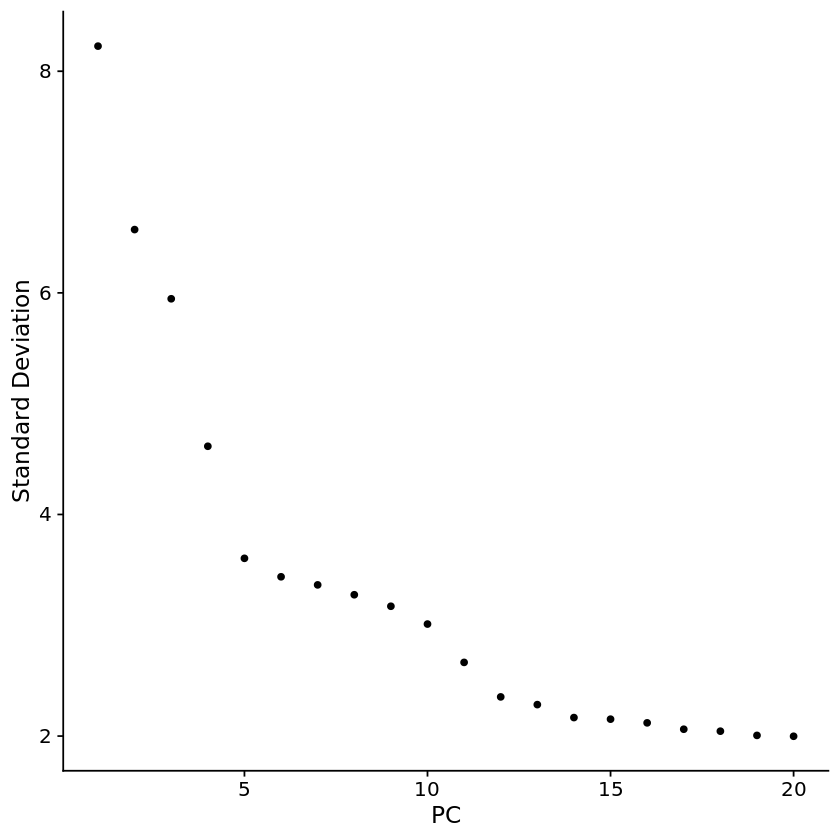

In [29]:
ElbowPlot(liver)

## Clustering the cells
Seurat v3 applies a graph-based clustering approach, building upon initial strategies in ([Macosko et al., 2015](https://www.cell.com/fulltext/S0092-8674(15)00549-8)). More details about this strategy are available in the orginal [Guided Clustering tutorial](https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html).

The `FindNeighbors()` function constructs a KNN graph based on the euclidean distance in PCA space, and refines the edge weights between any two cells based on the shared overlap in their local neighborhoods (Jaccard similarity). This step takes the previously defined dimensionality of the dataset (first 10 PCs) as input.

The `FindClusters()` function applies modularity optimization techniques such as the Louvain algorithm (default) or SLM ([SLM, Blondel et al., Journal of Statistical Mechanics](https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008)]), to iteratively group cells together, with the goal of optimizing the standard modularity function. 

The function contains a resolution parameter that sets the 'granularity' of the downstream clustering, with increased values leading to a greater number of clusters. 

The Seurat team finds that setting this parameter between 0.4-1.2 typically returns good results for single-cell datasets of around 3K cells. Optimal resolution often increases for larger datasets. 

The clusters can be found using the `Idents()` function.

In [30]:
# FindNeighbors uses the first 10 principle components
liver <- FindNeighbors(liver, dims = 1:10)
liver <- FindClusters(liver, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 906
Number of edges: 27164

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8533
Number of communities: 7
Elapsed time: 0 seconds


## Performing non-linear dimensinonal reduction (UMAP)

Seurat offers several non-linear dimensional reduction techniques, such as tSNE and UMAP, to visualize and explore these datasets. The goal of these algorithms is to learn the underlying manifold of the data in order to place similar cells together in low-dimensional space. Cells within the graph-based clusters determined above should co-localize on these dimension reduction plots. 

As input to the UMAP, the Seurat team suggests using the same PCs as input to the clustering analysis.

In [31]:
# If you haven't installed UMAP, you can do so via reticulate::py_install(packages =
# 'umap-learn')
liver <- RunUMAP(liver, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
19:00:46 UMAP embedding parameters a = 0.9922 b = 1.112

19:00:46 Read 906 rows and found 10 numeric columns

19:00:46 Using Annoy for neighbor search, n_neighbors = 30

19:00:46 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:00:47 Writing NN index file to temp file /tmp/RtmpbfIVMK/file9b3ccd1119

19:00:47 Searching Annoy index using 1 thread, search_k = 3000

19:00:47 Annoy recall = 100%

19:00:48 Commencing smooth kNN distance calibration using 1 thread

19:00:49 Initializing from n

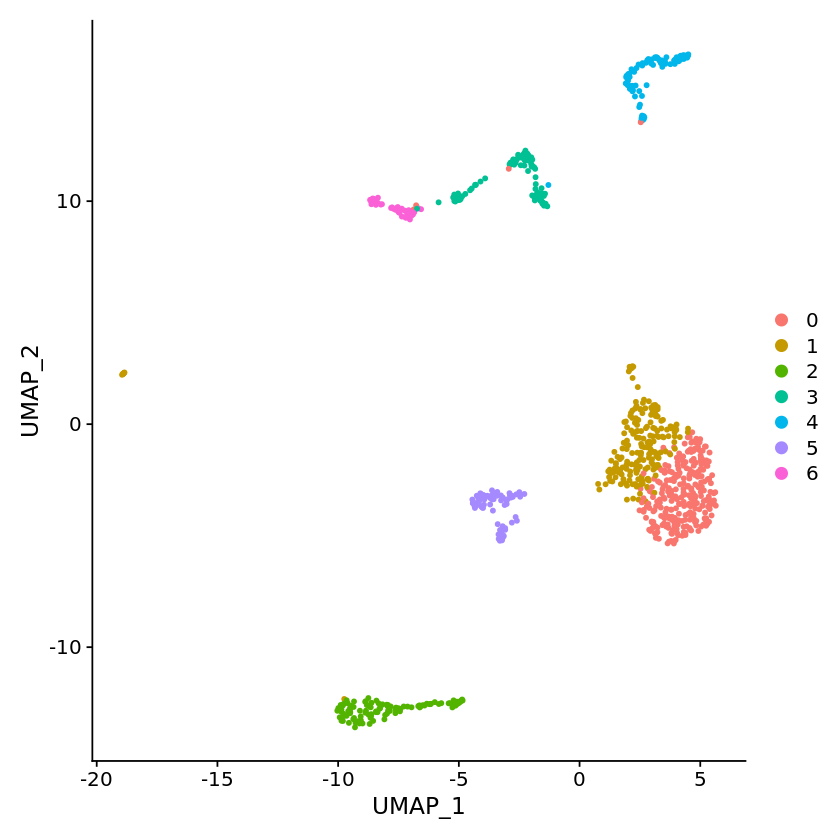

In [32]:
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters
DimPlot(liver, reduction = "umap")

You can save the object at this point so that it can easily be loaded back in without having to rerun the computationally intensive steps performed above, or easily shared with collaborators.

In [33]:
saveRDS(liver, file = "liver_seurat_clusters.rds")

## Performing differential expression analysis
Seurat can help you find markers that define clusters via differential expression. 

By default, it identifes positive and negative markers of a single cluster (specified in ident.1), compared to all other cells. 

`FindAllMarkers()` automates this process for all clusters, but you can also test groups of clusters vs. each other, or against all cells.

The `min.pct` argument requires a feature to be detected at a minimum percentage in either of the two groups of cells, and the thresh.test argument requires a feature to be differentially expressed (on average) by some amount between the two groups. You can set both of these to 0, but with a dramatic increase in time - since this will test a large number of features that are unlikely to be highly discriminatory. 

As another option to speed up these computations, use the `max.cells.per.ident()` function. This will downsample each identity class to have no more cells than whatever this is set to. While there is generally going to be a loss in power, the speed increases can be significiant and the most highly differentially expressed features will likely still rise to the top.

In [34]:
# find all markers of cluster 2
cluster2.markers <- FindMarkers(liver, ident.1 = 2, min.pct = 0.25)
head(cluster2.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AC020656.1,1.494248e-157,4.541742,0.947,0.024,8.718491e-153
AIF1,3.195190e-151,3.921206,0.965,0.039,1.864297e-146
LYZ,5.726295e-151,4.895742,0.982,0.043,3.341122e-146
CLEC7A,1.492917e-129,2.413686,0.690,0.001,8.710726e-125
LST1,4.391950e-125,2.800022,0.805,0.026,2.562571e-120


The resulting data frame above should have the following columns :

* **p_val** : p_val (unadjusted)


* **avg_logFC** : log fold-chage of the average expression between the two groups. Positive values indicate that the feature is more highly expressed in the first group


* **pct.1** : The percentage of cells where the feature is detected in the first group


* **pct.2** : The percentage of cells where the feature is detected in the second group; if no second group is specified, it considers all other cells from the first group


* **p_val_adj** : Adjusted p-value, based on bonferroni correction using all features in the dataset

In [35]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
liver.markers <- FindAllMarkers(liver, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
liver.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
3.484750e-67,2.130880,0.858,0.364,2.033247e-62,0,NKG7
3.040195e-29,2.705629,0.396,0.099,1.773863e-24,0,GNLY
2.112089e-39,1.825726,0.403,0.052,1.232341e-34,1,IL7R
4.672854e-08,1.565510,0.995,0.960,2.726470e-03,1,SAA2
5.726295e-151,4.895742,0.982,0.043,3.341122e-146,2,LYZ
1.980800e-92,5.454039,0.903,0.130,1.155737e-87,2,S100A9
3.730262e-111,3.641319,0.787,0.034,2.176496e-106,3,SPARCL1
5.316891e-90,3.646359,0.670,0.032,3.102246e-85,3,MGP
7.198553e-58,8.307648,0.988,0.383,4.200140e-53,4,HBA1


Seurat has several tests for differential expression which can be set with the `test.use` parameter (see the [DE vignette](https://satijalab.org/seurat/v3.0/de_vignette.html) for details). 

For example, the ROC test returns the 'classification power' for any individual marker (ranging from 0 - random, to 1 - perfect).

In [36]:
# Example of setting up differential expression testing with ROC method
cluster2.markers <- FindMarkers(liver, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)


In [37]:
# Save Seurat object
saveRDS(liver, file = "liver_final.rds")

## Copying output files to workspace Google bucket
Data generated by running an analysis in a Jupyter Notebook is saved to the disk associated with the Cloud Environment. When the disk is deleted, the data are as well. 

You can backup your work by moving files to your workspace Google bucket.


Remember those system environment variables set up at the beginning of this notebook? The code below uses those variables to simplify copying files to the workspace.


In [38]:
# Copy the rds file generated in the notebook into the workspace bucket using AnVIL package gsutil commands
gsutil_cp("./*.rds", bucket)
# Run list command to see if file is in the bucket
gsutil_ls(bucket)


Copying file://./liver_final.rds [Content-Type=application/octet-stream]...
Copying file://./liver_seurat.rds [Content-Type=application/octet-stream]...
Copying file://./liver_seurat_clusters.rds [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [3/3 files][530.2 MiB/530.2 MiB] 100% Done                                    
Oper

[1] "gs://fc-7324e65c-4d56-4a2e-973a-9c8f405bfce6/liver_final.rds"          
[2] "gs://fc-7324e65c-4d56-4a2e-973a-9c8f405bfce6/liver_seurat.rds"         
[3] "gs://fc-7324e65c-4d56-4a2e-973a-9c8f405bfce6/liver_seurat_clusters.rds"
[4] "gs://fc-7324e65c-4d56-4a2e-973a-9c8f405bfce6/notebooks/"

## Congrats!
You've successfully completed the Seurat tutorial for single-cell analysis of HCA data. Please leave feedback on the 
Terra [Featured Workspace Community Forum](https://support.terra.bio/hc/en-us/community/topics/360001603491). 